<a href="https://colab.research.google.com/github/ssttefann/EmotionClassification/blob/master/bag_of_words_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Emotion Classificaton in Text**

In [49]:
from __future__ import absolute_import, division, print_function, unicode_literals

# General
import numpy as np
import pandas as pd
import re

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot') 
# plt.style.use('dark_background')

try:
  import pyprind
except Exception:
  !pip install pyprind
  import pyprind

# Data preprocessing
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

# SKLEARN 
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the data

In [84]:
# set the seed for entire process
# so that results can be reproducible
np.random.seed(123)

dataset = pd.read_csv("/content/drive/My Drive/emotion.data")
dataset.drop(dataset.columns[0], axis='columns', inplace=True)    # drop id column since it won't be used 
dataset = dataset.reindex(np.random.permutation(dataset.index))   # shuffle data 
dataset.head()

,text,emotions
98301,i am feeling melancholy and have finally pinpo...,sadness
41147,i miss having someone to talk to who i have th...,joy
151024,i just feel like i get blamed for everything,sadness
202104,i also apologize for mentioning about him in m...,anger
73602,im finding is the difference in having a life ...,joy


# Visualization

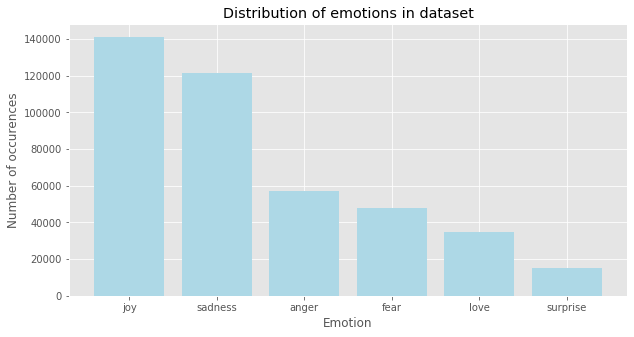

In [89]:
#x_ax = np.unique(dataset['emotions'])                                # more general way
x_ax = ['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']        # I did it by hand so the values are
y_ax = [ np.count_nonzero(dataset['emotions'] == x) for x in x_ax]

fig = plt.figure(figsize=(10, 5))
plt.bar(x_ax, y_ax, color='lightblue')
plt.title("Distribution of emotions in dataset")
plt.xlabel("Emotion")
plt.ylabel("Number of occurences")
# plt.savefig('/content/drive/My Drive/Colab Notebooks/individual/distribution.png')
plt.show()

## Word clouds

In [0]:
from wordcloud import WordCloud

def generate_word_cloud(input_text):
    wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(input_text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [0]:
############### INDIVIDUAL PLOTS

fig = plt.figure(figsize=(15, 8))

emotion = 'love'

df = dataset.loc[dataset['emotions'] == emotion]
df = df['text'].tolist()
wordcloud = WordCloud(max_font_size=80).generate(" ".join(df))
plt.axis("off")
plt.title(emotion)
plt.imshow(wordcloud)

#plt.savefig('/content/drive/My Drive/Colab Notebooks/individual/' + emotion +'.png')
plt.show()


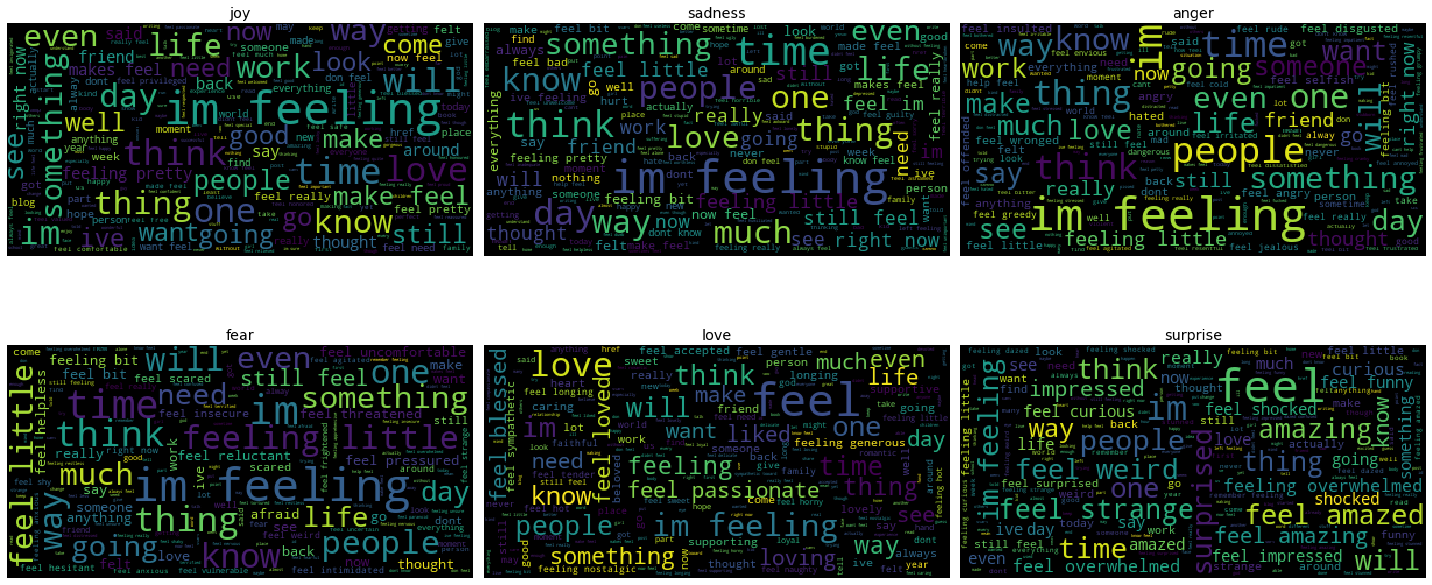

In [91]:
fig = plt.figure(figsize=(20, 10))

for idx,emotion in enumerate(x_ax):
  ax = fig.add_subplot(2, 3, idx+1)
  df = dataset.loc[dataset['emotions'] == emotion]
  df = df['text'].tolist()
  wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(" ".join(df))
  ax.axis("off")
  ax.set_title(emotion)
  ax.imshow(wordcloud)

plt.tight_layout()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/wc_facet.png')
plt.show()

# Preprocessing


 ## Stop words


In [92]:
try:
  stop = stopwords.words('english')
except LookupError:
  import nltk
  nltk.download('stopwords')
  stop = stopwords.words('english')

print(stop[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


## Tokenezing

In [0]:

def tokenizer(text):
    ''' Removes stop words and special characters,
        and returns list of all words that are left

        Parameters
        -----------
        text : string 

        Returns
        ----------
        tokenized : list {string}
    '''

    text = re.sub('http.*', '', text)                               # delete link references
    text = re.sub('[\W]+', ' ', text.lower()).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]          # skip stop words
    return tokenized


In [94]:
string = 'neko je nesto rekao http www.gocml'

re.sub('http.*', '', string)

'neko je nesto rekao '

## Stemming


In [0]:
porter = PorterStemmer() 
def tokenizer_porter(text):
  return [porter.stem(word) for word in tokenizer(text)]

# Creating Train and test data

In [133]:
label2id = {"joy" : 0, "sadness" : 1, "anger" : 2, "fear" : 3, "love" : 4, "surprise" : 5}
id2label = {0 : "joy", 1 : "sadness", 2 : "anger", 3 : "fear", 4 : "love", 5 : "surprise"}

label2col = {"joy":"yellow", "sadness":"blue", "anger":"red", "fear":"grey", "love":"pink", "surprise":"orange"}

#label2id = { label : idx for idx, label in enumerate(set(dataset['emotions'].values))}
#id2label = { id : label for label, id in label2id.items()}

print(label2id)
print(id2label)

{'joy': 0, 'sadness': 1, 'anger': 2, 'fear': 3, 'love': 4, 'surprise': 5}
{0: 'joy', 1: 'sadness', 2: 'anger', 3: 'fear', 4: 'love', 5: 'surprise'}


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset['text'].values, 
                                                    dataset['emotions'].values, 
                                                    test_size=0.1, 
                                                    random_state=123)

In [0]:
y_train = np.asarray([ label2id[val] for val in y_train])
y_test =  np.asarray([ label2id[val] for val in y_test])          

# Training the model


## Vectorization

In [0]:
# Hashing vectorizer
lr_vect = HashingVectorizer(decode_error='ignore', 
                         n_features=2**18,
                         preprocessor=None, 
                         tokenizer=tokenizer)

## Logistic Regression

In [100]:
# By setting the loss parameter to log loss this becomes a Logistic Regression Classifier
lr_clf = SGDClassifier(loss='log', random_state=1, max_iter=1)

num_epochs = 100
pbar = pyprind.ProgBar(num_epochs)
classes = [x for x in label2id.values()]

for i in range(num_epochs):

    # number of elements in one batch
    size = int(len(X_train) / num_epochs)

    #starting index of a batch
    start = size * i

    #last index of a batch
    end = start + size 

    batch_x = X_train[start : end]
    batch_y = y_train[start : end]

    batch_x = lr_vect.transform(batch_x)
    lr_clf.partial_fit(batch_x, batch_y, classes=classes)
    pbar.update()

# some elements are possibly left over because of integer division
# so do one final partial fit
batch_x = X_train[end : ]
batch_y = y_train[end : ]

batch_x = lr_vect.transform(batch_x)
lr_clf.partial_fit(batch_x, batch_y, classes=classes)
pbar.update()


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:23


In [0]:
def calculate_metrics(clf, vect):
  transformed = vect.transform(X_test)
  y_pred = clf.predict(transformed)

  # Calculate F-Score
  print(classification_report(y_test, y_pred))

  # Calculate Accuracy
  print('Accuracy: %.3f' % clf.score(transformed, y_test))

In [102]:
print("\nLogistic Regression: \n")

calculate_metrics(lr_clf, lr_vect)


Logistic Regression: 

              precision    recall  f1-score   support

           0       0.78      0.97      0.87     13977
           1       0.86      0.94      0.90     12088
           2       0.94      0.75      0.83      5835
           3       0.86      0.71      0.78      4707
           4       0.94      0.52      0.67      3584
           5       0.93      0.32      0.48      1490

    accuracy                           0.84     41681
   macro avg       0.88      0.70      0.75     41681
weighted avg       0.85      0.84      0.83     41681

Accuracy: 0.841


## SVM Approach

### TF IDF


In [103]:
# TF-IDF vectorizer
tfidf_vect = TfidfVectorizer(tokenizer=tokenizer)

# Linear SVC classifier 
tfidf_clf = LinearSVC()
tfidf_clf.fit(tfidf_vect.fit_transform(X_train), y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [104]:
print("\nLinear SVC with TF-IDF:\n")

calculate_metrics(tfidf_clf, tfidf_vect)


Linear SVC with TF-IDF:

              precision    recall  f1-score   support

           0       0.91      0.92      0.91     13977
           1       0.93      0.94      0.93     12088
           2       0.91      0.88      0.89      5835
           3       0.82      0.83      0.82      4707
           4       0.76      0.74      0.75      3584
           5       0.69      0.68      0.68      1490

    accuracy                           0.88     41681
   macro avg       0.84      0.83      0.83     41681
weighted avg       0.88      0.88      0.88     41681

Accuracy: 0.884


### Bigrams

In [106]:
# Bigram vectorizer
bigram_vect = CountVectorizer(ngram_range=(1, 2), tokenizer=tokenizer)

# Linear SVC classifier
bigram_clf = LinearSVC()
bigram_clf.fit(bigram_vect.fit_transform(X_train), y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [107]:
print("\nLinear SVC with Bigrams\n")

calculate_metrics(bigram_clf, bigram_vect)


Linear SVC with Bigrams

              precision    recall  f1-score   support

           0       0.90      0.91      0.91     13977
           1       0.94      0.94      0.94     12088
           2       0.90      0.89      0.89      5835
           3       0.80      0.82      0.81      4707
           4       0.72      0.70      0.71      3584
           5       0.66      0.66      0.66      1490

    accuracy                           0.88     41681
   macro avg       0.82      0.82      0.82     41681
weighted avg       0.88      0.88      0.88     41681

Accuracy: 0.878


# Evaluating models' performance


In [61]:
test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(test, y_test))

Accuracy: 0.841


# Testing on custom data

In [0]:
def predict(text, clf=tfidf_clf, vectorizer=tfidf_vect):
  ''' Predicts the label of the given text input

  Parameters
  ----------- 
  text : string
    text whose emotion we want to interpret
  clf : sklearn.linear_model
    Classifier
  vectorizer : sklearn.feature_extraction.text
    Vectorizer that represents text in a numerical form
  
  Returns 
  ----------
  label : string
    name of emotion which corresponds to the input

  '''

  #val = clf.predict(vectorizer.transform([text]))
  #return id2label[val[0]]


  arr = clf.decision_function(vectorizer.transform([text]))
  from scipy.special import softmax
  arr = softmax(arr[0])
  bar = plt.bar(x_ax, arr.tolist(), color='lightblue')
  # [bar[idx].set_color(label2col[emotion]) for idx, emotion in enumerate(x_ax)]
  plt.show()

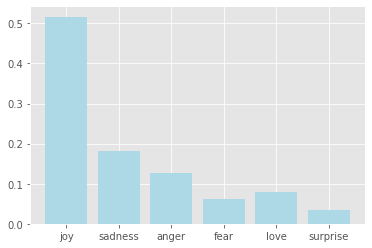

In [145]:
predict("Today has been a disaster so far", clf=lr_clf, vectorizer=lr_vect)

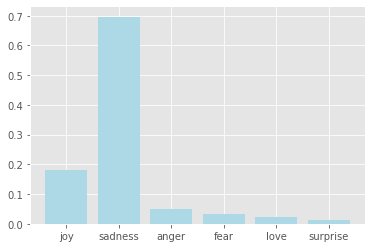

In [146]:
predict("Today has been a disaster so far. I feel so tired because my stupid boss made me do all his work", clf=lr_clf, vectorizer=lr_vect)

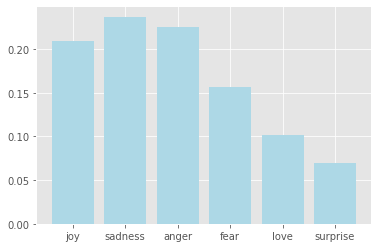

In [147]:
# Same as #1 only now using tfidf svm
predict("Today has been a disaster so far")

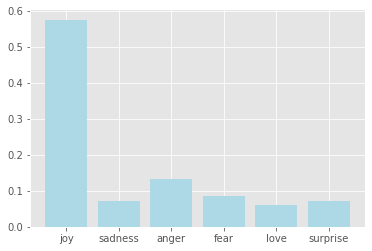

In [148]:
predict("The cucumber looked great, but when I peeled it off, some of it fell apart. But the rest still tasted fine I guess")

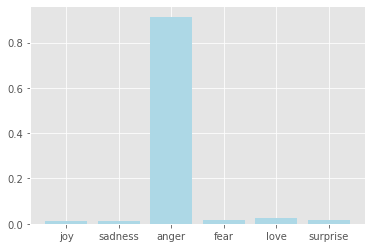

In [149]:
predict("My mom is so stubborn she won't let me go anywhere!")

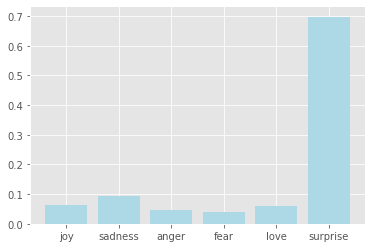

In [150]:
predict("When I found out Kobe Bryant died, i was shocked!")

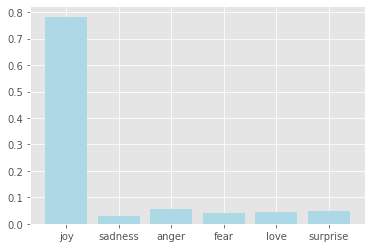

In [151]:
predict("I am not happy", tfidf_clf, tfidf_vect)

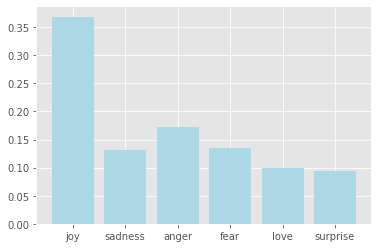

In [152]:
predict("I am not happy", bigram_clf, bigram_vect)

In [153]:
bigram_clf.decision_function(bigram_vect.transform(['I am not happy']))

array([[ 0.19614176, -0.83792357, -0.56680765, -0.8113268 , -1.11407189,
        -1.16726619]])